Q. A data scientist is working on optimizing a model during the training process by varying multiple parameters. The data scientist observes that, during multiple runs with identical parameters, the loss function converges to different, yet stable, values. 

A. Increase the learning rate. Keep the batch size the same. [REALISTIC DISTRACTOR]

B. Reduce the batch size. Decrease the learning rate. [CORRECT] 

C. Keep the batch size the same. Decrease the learning rate. [REALISTIC DISTRACTOR]

D. Do not change the learning rate. Increase the batch size. [REALISTIC DISTRACTOR]

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from collections import defaultdict
from itertools import zip_longest
from functools import partial

>We shall restrict our attention to 3-dimensional problems for right now (i.e. optimizing over only 2 parameters), though what follows can be extended to higher dimensions by plotting all pairs of parameters against each other, effectively projecting the problem to 3-dimensions.

>The Wikipedia article on Test functions for optimization has a few functions that are useful for evaluating optimization algorithms. In particular, we shall look at Beale's function:

$$
f(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2
$$

http://louistiao.me/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/

In [4]:
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [83]:
init0 = np.array([4., 4.]).reshape(-1, 1)
init1 = np.array([-4., 4.]).reshape(-1, 1)
init2 = np.array([-4., -4.]).reshape(-1, 1)
init3 = np.array([4., -4.]).reshape(-1, 1)

In [84]:
xmin, xmax, xstep = -5.0, 5.0, .2
ymin, ymax, ystep = -5.0, 5.0, .2

In [85]:
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

In [86]:
z = f(x, y)

We know the global minima is at $(3, 0.5)$

In [87]:
minima = np.array([3., .5])
f(*minima)

0.0

In [88]:
minima_ = minima.reshape(-1, 1)
minima_
f(*minima)

0.0

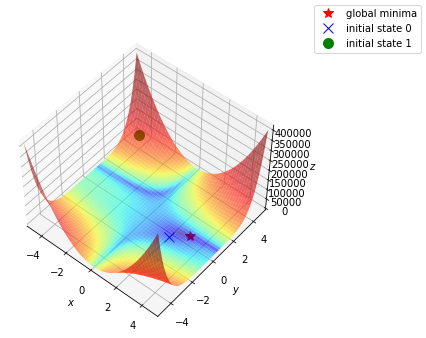

In [92]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.6, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10, label="global minima")
ax.plot(*init0, f(*init0), 'bx', markersize=10, label="initial state 0")
ax.plot(*init1, f(*init1), 'go', markersize=10, label="initial state 1")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
fig.legend()
plt.show()

In [167]:
np.random.normal(loc=0.0, scale=1.0, size=init0.size)

array([ 1.04039611, -0.10218068])

In [210]:
def numerical_gradient(f, x, h = 1e-04):
    grad = np.zeros_like(x)
    for dim in range(x.size):
        tmp = x[dim]
        # calculate f(x+h)
        x[dim] = tmp + h
        fxh1 = f(*x)
        # calculate f(x-h)
        x[dim] = tmp - h
        fxh2 = f(*x)
        grad[dim] = (fxh1 - fxh2) / (2.*h)
        x[dim] = tmp
    return grad

def gradient_descent_with_noise(f, init_x, lr=0.01, step_num=100, noise=1e-03):
    x = init_x
    for i in range(step_num):
        tmp = x.copy()
        yield tmp        
        grad = numerical_gradient(f, x)
        if noise:
            grad += np.random.normal(loc=0.0, scale=noise, size=grad.size).reshape(-1, 1)
        x -= lr * grad

In [211]:
def simulate(init, lr=1e-04, noise=1e+01):
    res = [
        *gradient_descent_with_noise(
            f, init, lr=lr, step_num=int(1e+05), noise=noise
        )
    ]

    path = np.array(res)
    xs = path[:, 0].flatten()
    ys = path[:, 1].flatten()
    zs = np.array([f(x, y) for x, y in zip(xs, ys)])

    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection='3d', elev=50, azim=-50)

    ax.plot_surface(
        x, y, z, norm=LogNorm(),
        rstride=1, cstride=1, edgecolor='none',
        alpha=.6, cmap=plt.cm.jet)
    ax.plot(xs, ys, zs, "b-")
    ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    plt.show()

まず，問題の想定している状況を確認する． ここで設定しているような関数に対してNaiveにGradient Decent Algorithmを適用すると初期値によって収束先が異なる

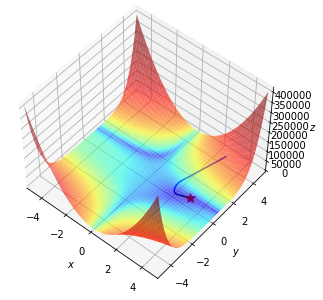

In [213]:
init0 = np.array([3., 4.]).reshape(-1, 1)
simulate(init0, lr=1e-04, noise=None)

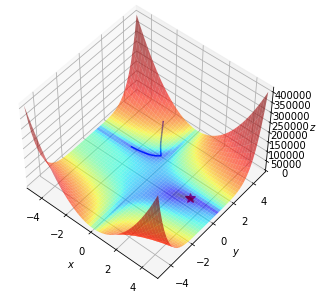

In [215]:
init1 = np.array([-2., 4.]).reshape(-1, 1)
simulate(init1, lr=1e-04, noise=None)

ここで，batch_sizeを小さくすることがgradientに対するnoiseを大きくすることに対応すると考えて平均$0$, 標準偏差が`noise`の正規分布に従う乱数をgradientに加えてみます

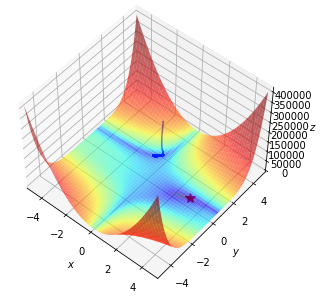

In [233]:
init1 = np.array([-2., 4.]).reshape(-1, 1)
simulate(init1, lr=1e-05, noise=1e+02)

このとき単純に`noise`を大きくしてしまうと学習が収束しません

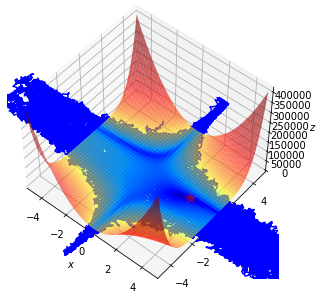

In [226]:
init1 = np.array([-2., 4.]).reshape(-1, 1)
simulate(init1, lr=1e-05, noise=1e+04)

そこで同時に学習率を下げることで，local minimaにtrapされることを避けつつ学習が収束するようにしてやります

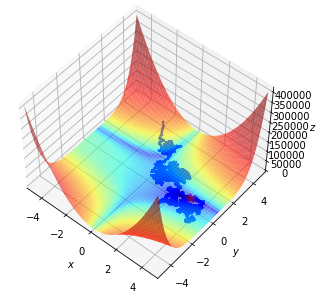

In [225]:
init1 = np.array([-2., 4.]).reshape(-1, 1)
simulate(init1, lr=1e-06, noise=1e+04)

このようにすると，学習の初期の段階で，noiseがうまく作用してくれれば，local minimaにtrapされず，global minamaまで淘汰することができる（こともある）

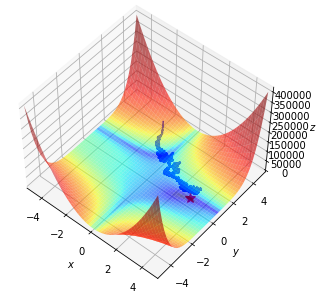

In [230]:
init1 = np.array([-2., 4.]).reshape(-1, 1)
simulate(init1, lr=5e-07, noise=1e+04)

Stochastically get out of the local minimaとある通り必ずしもうまくいくわけでは無い

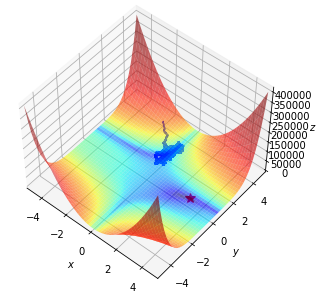

In [231]:
init1 = np.array([-2., 4.]).reshape(-1, 1)
simulate(init1, lr=5e-07, noise=1e+04)

また，あんまり学習率を下げすぎるとlocal minimaにトラップされる

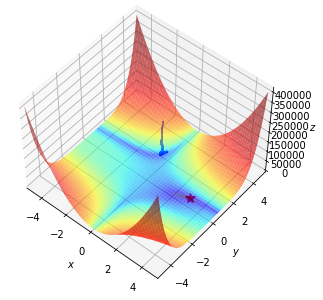

In [228]:
init1 = np.array([-2., 4.]).reshape(-1, 1)
simulate(init1, lr=1e-07, noise=1e+04)